In [1]:
#import libraries

import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile 
import keras.backend as K
from sklearn.model_selection import train_test_split



from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

from tensorflow.keras import layers, models

C:\Users\gassaf\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
import sys
print("Python Version:", sys.version)
print("Python Version Info:", sys.version_info)

import tensorflow as tf

print("TensorFlow Version:", tf.__version__)


Python Version: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Python Version Info: sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
TensorFlow Version: 2.13.0


In [3]:
print(os.getcwd())

C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP


In [4]:
#code to create the required directory if needed
#print(os.getcwd())
#creating the folders based on the list of folder name

#orig_data_dir is the main folder of original images
orig_data_dir="AerialImageDataset"
orig_images_dir_X_train=os.path.join(orig_data_dir,"train","images")
orig_images_dir_y_train=os.path.join(orig_data_dir,"train","gt")

print(orig_images_dir_X_train)
#folder names of destination after tiling the images
list_foldersnames = ['train', 'train_masks']

#Creating the desination directory folders
for folder in list_foldersnames:
    folder_path = os.path.join(os.getcwd(), folder)
    if not os.path.exists(folder_path):
         os.mkdir(folder_path)
         print(f"Folder created sucessfully: {folder_path}")
    else:
          print(f"Folder {folder_path} is available")
        #print(folder_path)


AerialImageDataset\train\images
Folder C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train is available
Folder C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train_masks is available


In [5]:
#tiling the images based on a specific tile_sie
def tile_image(input_path, output_folder, tile_size,file_name):
    
    #print(file_name)
    # Open the input image

    input_image = Image.open(os.path.join(input_path))

    # Get the dimensions of the input image
    input_width, input_height = input_image.size

    # Calculate the number of tiles in both dimensions
    num_tiles_x = input_width // tile_size
    num_tiles_y = input_height // tile_size

    # Extract tiles and save them
    for i in range(num_tiles_x):
        for j in range(num_tiles_y):
            # Calculate the cropping box
            left = i * tile_size
            upper = j * tile_size
            right = left + tile_size
            lower = upper + tile_size

            # Crop the tile from the input image
            tile = input_image.crop((left, upper, right, lower))

            # Save the tile to the output folder
            tile.save(os.path.join(output_folder, f'{file_name}__tile_{i}_{j}.png'))


# Tiling Images

In [6]:
#Defining the parameters for tiling images

#Tile size of output image
tile_size = 250

## Tiling the Train Imges Dataset

In [7]:
#setting the output folder to train folder in the main directory
output_folder = os.path.join(os.getcwd(),list_foldersnames[0])
"""
#looping through 
for dirpath,dirnames,filenames in os.walk(orig_images_dir_X_train):
    for filename in filenames:
        input_path=os.path.join(dirpath,filename)
        filename=filename[:-4]
        tile_image(input_path, output_folder, tile_size,filename)
        
    # dirpath it will list all the directories(full path available under data_dir)
    # dirnames: it lists all the folders available under dirpath
    #filenames: it lists all the files available under dirpath
"""

'\n#looping through \nfor dirpath,dirnames,filenames in os.walk(orig_images_dir_X_train):\n    for filename in filenames:\n        input_path=os.path.join(dirpath,filename)\n        filename=filename[:-4]\n        tile_image(input_path, output_folder, tile_size,filename)\n        \n    # dirpath it will list all the directories(full path available under data_dir)\n    # dirnames: it lists all the folders available under dirpath\n    #filenames: it lists all the files available under dirpath\n'

## Tiling the Label Imges Dataset

In [8]:
"""
#setting the output folder to train folder in the main directory
output_folder = os.path.join(os.getcwd(),list_foldersnames[1])

#looping through 
for dirpath,dirnames,filenames in os.walk(orig_images_dir_y_train):
    for filename in filenames:
        input_path=os.path.join(dirpath,filename)
        filename=filename[:-4]
        tile_image(input_path, output_folder, tile_size,filename)
"""

'\n#setting the output folder to train folder in the main directory\noutput_folder = os.path.join(os.getcwd(),list_foldersnames[1])\n\n#looping through \nfor dirpath,dirnames,filenames in os.walk(orig_images_dir_y_train):\n    for filename in filenames:\n        input_path=os.path.join(dirpath,filename)\n        filename=filename[:-4]\n        tile_image(input_path, output_folder, tile_size,filename)\n'

In [9]:
for dirpath,dirnames,filenames in os.walk(orig_images_dir_y_train):
    print(f"dirpath: {dirpath} dirnames: {dirnames}")

dirpath: AerialImageDataset\train\gt dirnames: []


In [10]:
images=[]
labels=[]

In [11]:
for dirpath,dirnames,filenames in os.walk(os.path.join(os.getcwd(),list_foldersnames[0])):
    for filename in filenames:
        images.append(os.path.join(dirpath,filename))
print(len(images))        

1200


In [12]:
def prepare_dataframe(image_path,name):
    solar_ids = []
    paths = []
    for dirname, _, filenames in os.walk(image_path): #loop through all the images under all the directory image_path
        filenames = [filename for filename in filenames if not filename.startswith('.')]
        for filename in filenames:
            path = os.path.join(dirname, filename)    
            paths.append(path)

            solar_id = filename.split(".")[0]
            solar_ids.append(solar_id)

    d = {"id": solar_ids, name: paths}
    df = pd.DataFrame(data = d)
    #df = df.set_index('id')
    #df.reset_index()
    return df    

In [13]:
pd.set_option('display.max_colwidth', None)
image_root=os.getcwd() + '\\train'
df=prepare_dataframe(image_root,"roof_path")
#print(df.shape)

label_root=os.getcwd() + '\\train_masks'
mask_df=prepare_dataframe(label_root,"mask_path")

df=df.merge(mask_df,on='id')

print(df.shape)

df.head()
df.set_index('id',drop=True,inplace=True)

print(df.shape)
df.head()

(1200, 3)
(1200, 2)


roof_path  \
id                                                                                                                                                       
austin10__tile_0_0    C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train\austin10__tile_0_0.png   
austin10__tile_0_1    C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train\austin10__tile_0_1.png   
austin10__tile_0_10  C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train\austin10__tile_0_10.png   
austin10__tile_0_11  C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train\austin10__tile_0_11.png   
austin10__tile_0_12  C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train\austin10__tile_0_12.png   

                                                                                                                                                   mask_path  
id                                                                                                                                                            
austin10__tile_0_0    C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train_masks\austin10__tile_0_0.png  
austin10__tile_0_1    C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train_masks\austin10__tile_0_1.png  
austin10__tile_0_10  C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train_masks\austin10__tile_0_10.png  
austin10__tile_0_11  C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train_masks\austin10__tile_0_11.png  
austin10__tile_0_12  C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train_masks\austin10__tile_0_12.png

In [14]:
print(df['roof_path'][0])

C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\train\austin10__tile_0_0.png


C:\Users\gassaf\AppData\Local\Temp\ipykernel_2440\93310296.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df['roof_path'][0])


C:\Users\gassaf\AppData\Local\Temp\ipykernel_2440\1575058167.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img=Image.open(df['roof_path'][i])
C:\Users\gassaf\AppData\Local\Temp\ipykernel_2440\1575058167.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_mask=Image.open(df['mask_path'][i])


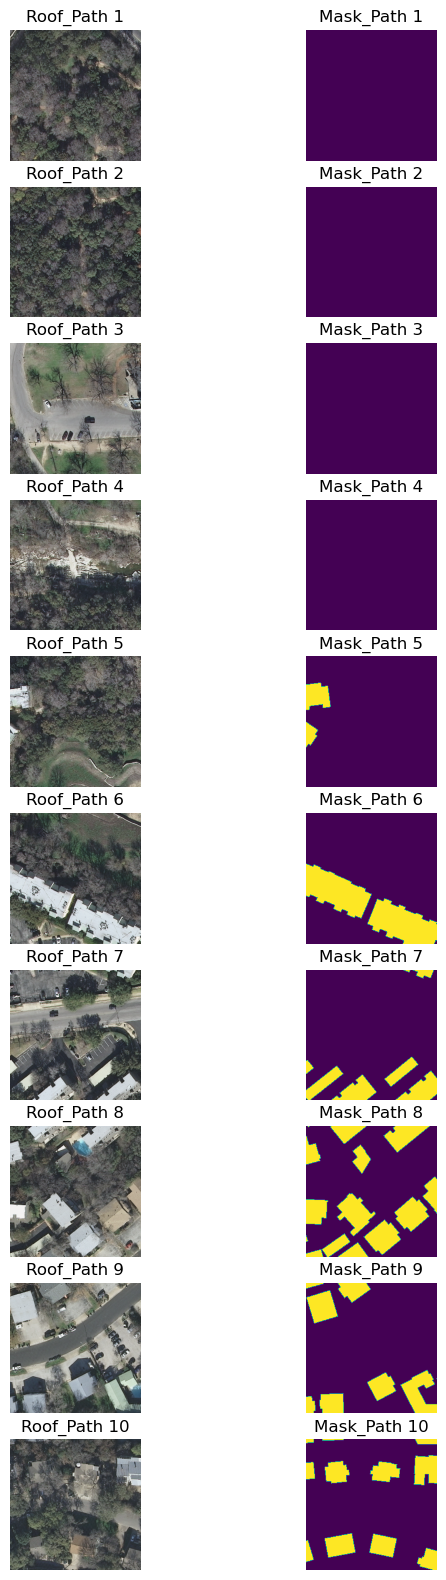

In [15]:
fig, axs = plt.subplots(10, 2, figsize=(7, 20))
 
for i in range(10):
    img=Image.open(df['roof_path'][i])
    # Convert the image to RGB format if it's not already in RGB
    if img.mode != "RGB":
        img = img.convert("RGB")
 # Convert the image to a NumPy array
    img_array = np.array(img)
    axs[i,0].imshow(img_array)
    axs[i,0].axis('off')
    axs[i, 0].set_title(f'Roof_Path {i+1}')

    img_mask=Image.open(df['mask_path'][i])
    # Convert the image to RGB format if it's not already in RGB
    if img.mode != "RGB":
        img = img.convert("RGB")
 # Convert the image to a NumPy array
    img_mask_array = np.array(img_mask)
    axs[i,1].imshow(img_mask_array)
    axs[i,1].axis('off')
    axs[i, 1].set_title(f'Mask_Path {i+1}')


In [16]:
import tensorflow as tf

In [17]:
img_size=(250,250)

def data_augmentation(solar_img, mask_img):

    if tf.random.uniform(()) > 0.5:
        solar_img = tf.image.flip_left_right(solar_img)
        mask_img = tf.image.flip_left_right(mask_img)


def preprocessing(solar_path, mask_path):
    solar_img = tf.io.read_file(solar_path) 
    solar_img = tf.image.decode_image(solar_img, channels=3, dtype=tf.float32,expand_animations=False)
    solar_img = tf.image.resize(solar_img,img_size)
    solar_img = tf.cast(solar_img, tf.float32) / 255.0
    #solar_img=tf.reshape(solar_img, (250,250,3))
        
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_image(mask_img, channels=1, dtype=tf.float32,expand_animations=False)
    mask_img = tf.image.resize(mask_img,img_size)
    #solar_img=tf.reshape(solar_img, (250,250,3))
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    
    return solar_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["roof_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        #ds = ds.batch(16)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["roof_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        #ds = ds.batch(16)
        #ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

def display(display_list):
    plt.figure(figsize=(15, 15))
#    title = ['Input Image', 'True Mask', 'Predicted Mask']
    title = ['Input Image', 'True Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [18]:
"""
ds = tf.data.Dataset.from_tensor_slices((df["roof_path"].values, df["mask_path"].values))

ds = ds.map(preprocessing)
ds = ds.batch(2)

for img_path, mask_path in ds:
    #solar_img = tf.io.read_file(img_path)
    #print(solar_img)
    #print(img_path)
    display(img_path)
    display(mask_path)
    #print(mask_path)
    break
    """

'\nds = tf.data.Dataset.from_tensor_slices((df["roof_path"].values, df["mask_path"].values))\n\nds = ds.map(preprocessing)\nds = ds.batch(2)\n\nfor img_path, mask_path in ds:\n    #solar_img = tf.io.read_file(img_path)\n    #print(solar_img)\n    #print(img_path)\n    display(img_path)\n    display(mask_path)\n    #print(mask_path)\n    break\n    '

In [19]:
# Now we will split the dataset into train and test
train_df, test_df = train_test_split(df,random_state=42, test_size=.20)
train_df, valid_df = train_test_split(train_df,random_state=42, test_size=.20)

train = create_dataset(train_df, train = True)
test = create_dataset(test_df)
valid = create_dataset(valid_df)

In [20]:
type(train)

tensorflow.python.data.ops.map_op._ParallelMapDataset

In [21]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 24
BUFFER_SIZE = 1000

In [22]:
#train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train.batch(BATCH_SIZE).repeat()

train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

valid_dataset = valid.batch(BATCH_SIZE)

In [23]:
print(type(train))
print(list(train.as_numpy_iterator()))


<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>
[(array([[[0.00089196, 0.00095348, 0.00104575],
        [0.00070742, 0.00075356, 0.00078431],
        [0.00063053, 0.00067666, 0.0007228 ],
        ...,
        [0.00075356, 0.0009381 , 0.00096886],
        [0.00075356, 0.0009381 , 0.00096886],
        [0.00076894, 0.00098424, 0.00101499]],

       [[0.00076894, 0.00083045, 0.00089196],
        [0.00067666, 0.0007228 , 0.00076894],
        [0.00069204, 0.00075356, 0.00079969],
        ...,
        [0.00075356, 0.00095348, 0.00098424],
        [0.00070742, 0.00087659, 0.00087659],
        [0.00075356, 0.00096886, 0.00098424]],

       [[0.00073818, 0.00078431, 0.00081507],
        [0.00070742, 0.00075356, 0.00081507],
        [0.00067666, 0.00075356, 0.00079969],
        ...,
        [0.00073818, 0.0009381 , 0.0009381 ],
        [0.00073818, 0.0009381 , 0.00095348],
        [0.00073818, 0.00092272, 0.00092272]],

       ...,

       [[0.00164552, 0.00163014, 0.00146098],
  

<_ParallelMapDataset element_spec=(TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(250, 250, 1), dtype=tf.float32, name=None))>


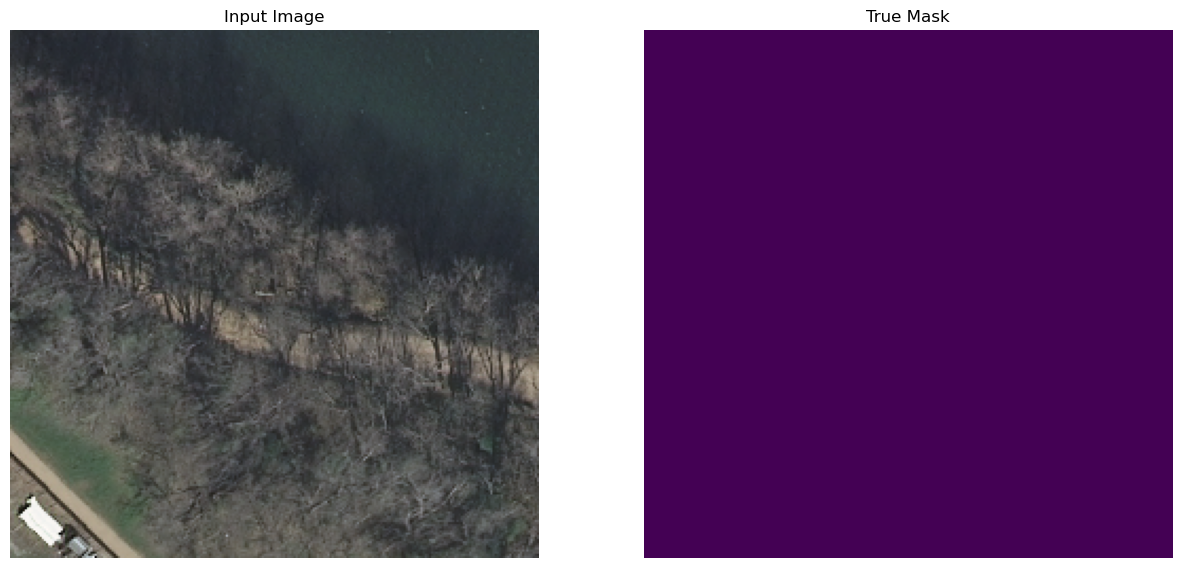

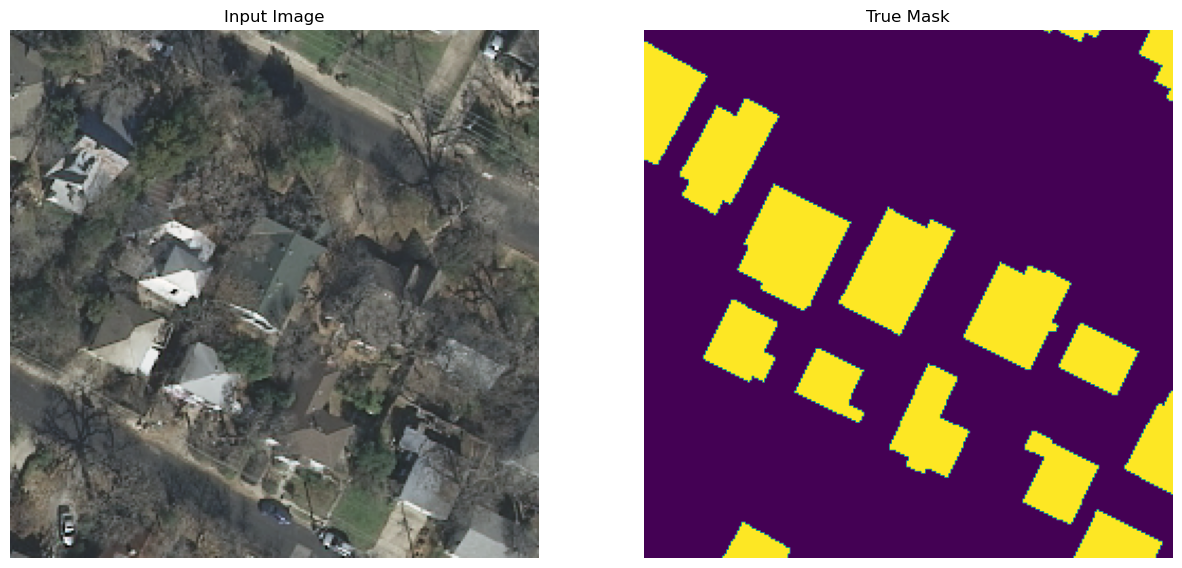

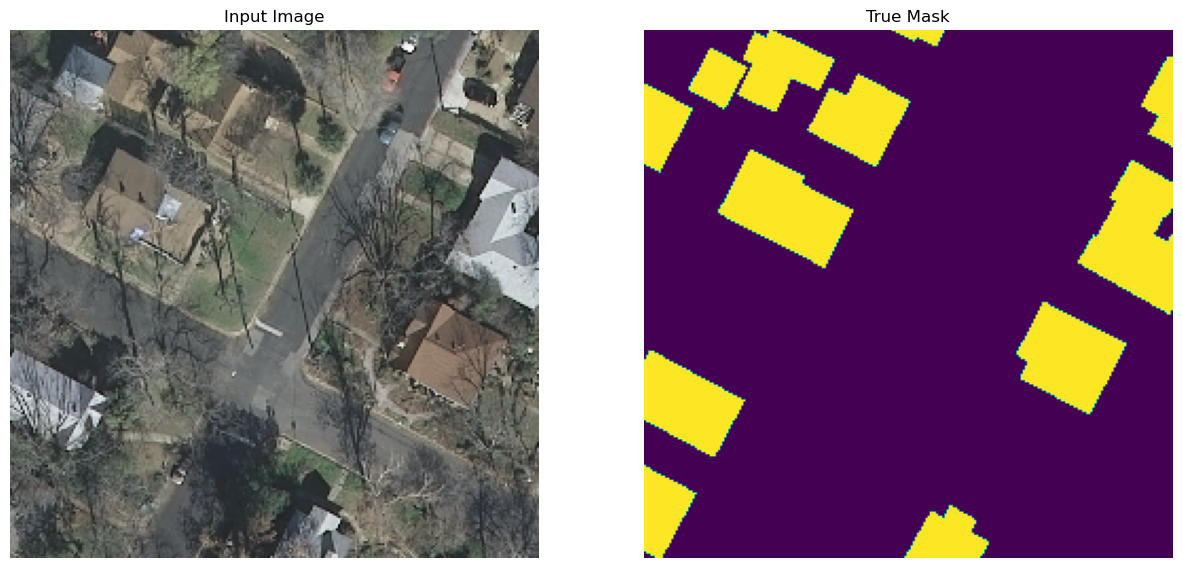

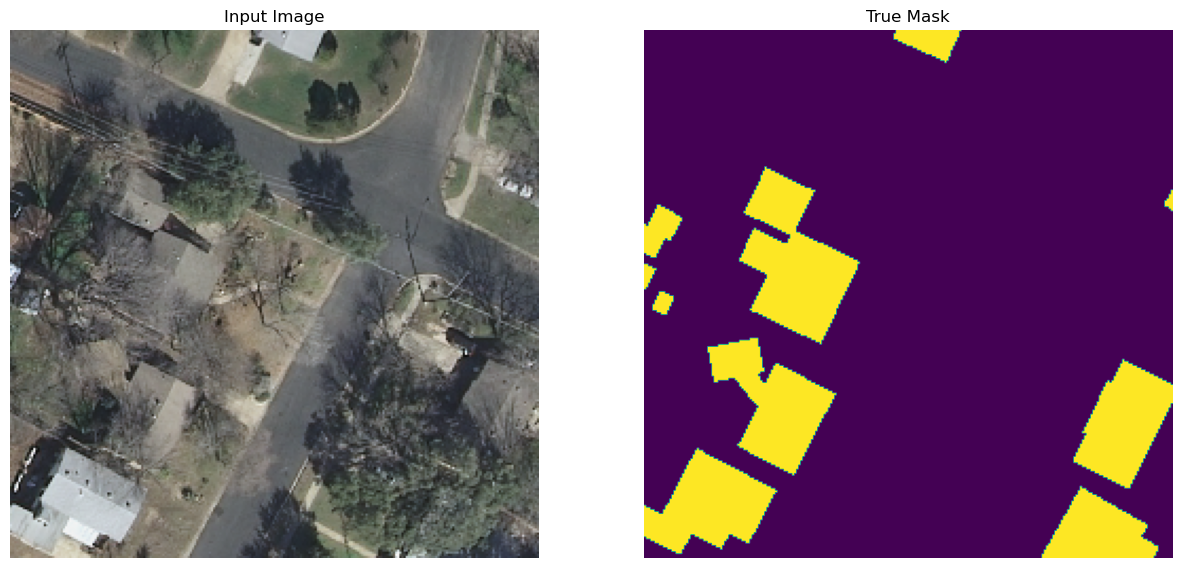

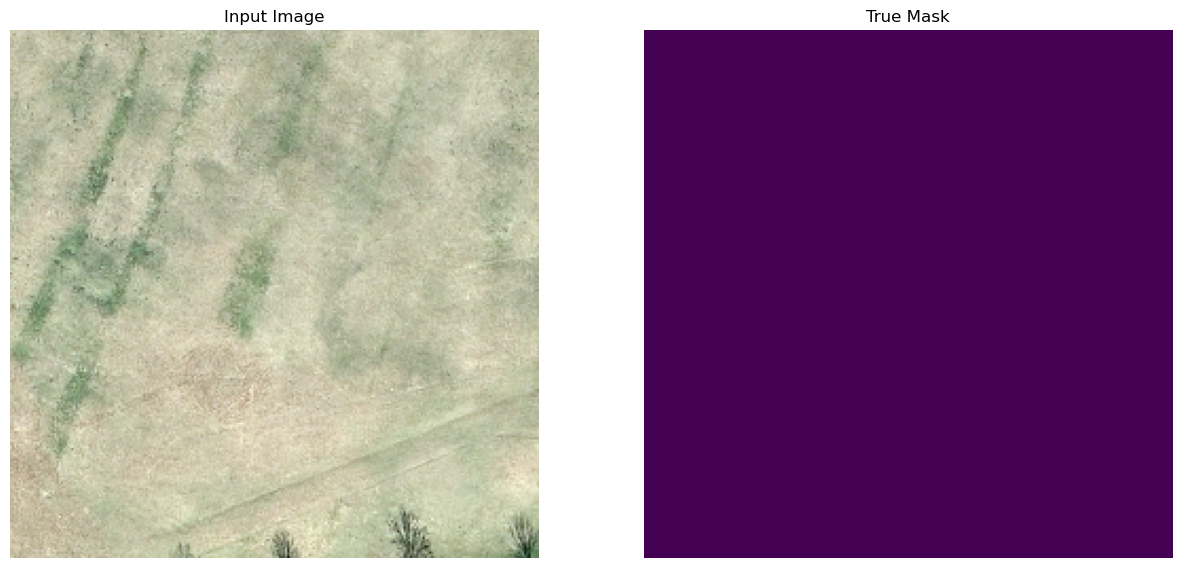

In [24]:

# Let's look the image and it's corresponding mask
print(train)
#for i in range(5):
for image, mask in train.take(5):
    #print(image)
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

# Model

In [25]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[250, 250, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [26]:
#base_model.get_layer('block_10_expand_relu').output


# Training the model

In [27]:
# This is for dice coefficient
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)




In [28]:

def unet_model(input_shape=(250, 250, 3)):
    inputs = tf.keras.Input(shape=input_shape)
 
    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
 
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
 
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
 
    # Bottleneck
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)
 
    # Decoder
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat5 = layers.Concatenate()([conv3, up5])
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv5)
 
    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    pad6 = layers.ZeroPadding2D(padding=((1, 0), (1, 0)))(up6)  # Pad to match dimensions
    concat6 = layers.Concatenate()([conv2, pad6])
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv6)
 
    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    concat7 = layers.Concatenate()([conv1, up7])
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv7)
 
    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv7)
 
    model = models.Model(inputs=inputs, outputs=outputs)
    return model
 
# Create the U-Net model
model = unet_model()
 
# Display the model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 250, 250, 32)         896       ['input_2[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 250, 250, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 125, 125, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                         

In [29]:
"""
# Adjusted input shape
input_shape = (250, 250, 3)

def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
 
    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
 
    # Bottleneck
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
 
    # Decoder
    up3 = layers.UpSampling2D(size=(2, 2))(conv2)
    concat3 = layers.Concatenate()([conv1, up3])
    conv3 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat3)
    conv3 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv3)
 
    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv3)
 
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create the U-Net model
model = unet_model(input_shape)
 
# Display the model summary
model.summary()

"""

"\n# Adjusted input shape\ninput_shape = (250, 250, 3)\n\ndef unet_model(input_shape):\n    inputs = tf.keras.Input(shape=input_shape)\n \n    # Encoder\n    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)\n    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)\n    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)\n \n    # Bottleneck\n    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)\n    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)\n \n    # Decoder\n    up3 = layers.UpSampling2D(size=(2, 2))(conv2)\n    concat3 = layers.Concatenate()([conv1, up3])\n    conv3 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat3)\n    conv3 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv3)\n \n    # Output layer\n    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv3)\n \n    model = models.Model(inputs=inputs, outputs=outputs)\n    return model\n\n# Create the U-Net mo

In [30]:
neg=72000*250*250*0.84
print(neg)
pos=72000*250*250*0.16
print(pos)
tot=72000*250*250

weight_for_0=(1/neg)*(tot/2)


weight_for_1=(1/pos)*(tot/2)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

3780000000.0
720000000.0
Weight for class 0: 0.60
Weight for class 1: 3.12


In [31]:
#model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

#losses=[dice_loss]

#losses=['binary_crossentropy',dice_loss]

losses=['binary_crossentropy']

#metrics=['accuracy',dice_coef,jaccard_metric,tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0,1])]

#metrics=['accuracy',dice_coef,tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)]

#metrics=['accuracy',dice_coef,"IoU"]
#model.compile(optimizer='adam',loss = dice_loss,metrics=[dice_coef,'binary_accuracy'])
#model.compile(optimizer="adam",loss=losses,metrics=metrics)
metrics=['accuracy',tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.5)]


model.compile(optimizer='adam', loss = losses, metrics=metrics)


In [32]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def jaccard_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    return intersection / union

In [33]:
#function for IoU
"""
from tf.keras.metrics import IoU
tf.keras.metrics.IoU(
    num_classes: int,
    target_class_ids: Union[List[int], Tuple[int, ...]],
    name: Optional[str] = None,
    dtype: Optional[Union[str, tf.dtypes.DType]] = None,
    ignore_class: Optional[int] = None,
    sparse_y_true: bool = True,
    sparse_y_pred: bool = True,
    axis: int = -1
)
"""
m = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0,1])
m.update_state([0, 0, 1, 1], [0, 1, 0, 1])
m.result().numpy()

0.33333334

In [34]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 24
BUFFER_SIZE = 1000

In [35]:
#train=tf.expand_dims(train,axis=-1)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

#EPOCHS = 10

checkpoint_filepath = os.getcwd()
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)





EPOCHS = 80
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

nbr_of_images=72000
neg=nbr_of_images*250*250*0.84
print(neg)
pos=nbr_of_images*250*250*0.16
print(pos)
tot=nbr_of_images*250*250

weight_for_0=(1/neg)*(tot/2)
weight_for_1=(1/pos)*(tot/2)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))


history=model.fit(train_dataset,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_data=valid_dataset,class_weight=class_weight,callbacks=[model_checkpoint_callback,early_stop])

3780000000.0
720000000.0
Weight for class 0: 0.60
Weight for class 1: 3.12
32/32 [==============================] - ETA: 0s - loss: 0.6344 - accuracy: 0.8717 - binary_io_u: 0.4359INFO:tensorflow:Assets written to: C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\assets


INFO:tensorflow:Assets written to: C:\Users\gassaf\Documents\01_AI_ML_Training_GeorgesAssaf\DDSTrainingCohort3\DDSFinalProject\ROOFTOP\assets


32/32 [==============================] - 338s 11s/step - loss: 0.6344 - accuracy: 0.8717 - binary_io_u: 0.4359 - val_loss: 0.6528 - val_accuracy: 0.8778 - val_binary_io_u: 0.4389


In [36]:
# Save the training history using pickle

from datetime import datetime
current_datetime = datetime.now()

formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")


import pickle
with open(f"history{formatted_datetime}.pkl", "wb") as file:
    pickle.dump(history.history, file)
    
print("History is saved")
    

History is saved


In [37]:
from datetime import datetime
current_datetime = datetime.now()

formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Create a filename with the formatted date and time
filename = f"data_{formatted_datetime}.txt"  # You can replace 'data' with your desired filename prefix

model.save(f"model_{formatted_datetime}.h5")
print("Saved model to disk")

Saved model to disk


C:\Users\gassaf\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
model.save('model_test01.h5')

In [39]:
!pip freeze

absl-py==1.4.0
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
altair==5.1.2
anaconda-client==1.11.0
anaconda-navigator==2.3.1
anaconda-project @ file:///C:/Windows/TEMP/abs_91fu4tfkih/croots/recipe/anaconda-project_1660339890874/work
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
appdirs==1.4.4
aquirdturtle-collapsible-headings==3.1.0
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
arguments==76
arrow @ file:///opt/conda/conda-bld/arrow_1649166651673/work
astroid @ file:///C:/Windows/TEMP/abs_b0dtxgpicv/croots/recipe/astroid_1659023126745/work
astropy @ file:///C:/ci/astropy_1657719656942/work
astunparse==1.6.3
atomicwrites==1.4.0
attrs==23.1.0
Automat @ file:///tmp/build/80754af9/automat_1600298431173/work
autopep8 @ file:///opt/conda/conda-bld/autopep8_1650463822033/work
Babel @ file:///tmp/build/80754af9/babel_1620871417480/work
backcall @ file:///home/ktie

In [40]:
#loaded_history

In [41]:
history.history

print(f"Average loss is: {np.mean(history.history['loss'])}")
print(f"Average accuracy is: {np.mean(history.history['binary_accuracy'])}")



Average loss is: 0.6343916654586792


KeyError: 'binary_accuracy'

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
    plt.figure(figsize=(15,6))

    plt.subplot(1,2,1)

    epochs = range(1, len(history.history["loss"]) + 1)
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.subplot(1,2,2)

    epochs = range(1, len(history.history["binary_accuracy"]) + 1)
    accuracy = history.history["binary_accuracy"]
    val_accuracy = history.history["val_binary_accuracy"]
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation binary accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()

In [ ]:
plot_history(history)

In [ ]:
print(train)
plot_history(history)

In [ ]:
#code shared by Tseyi
"""
def create_mask(pred_mask):

    pred_mask = tf.math.argmax(pred_mask, axis=-1)

    pred_mask = pred_mask[..., tf.newaxis]

    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_pred([image[0], mask[0], create_mask(pred_mask)])
    else:

        display_pred([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])

def display_pred(display_list):

    plt.figure(figsize=(15, 15))
 
    title = ['Input Image', 'True Mask', 'Predicted Mask']
 
    for i in range(len(display_list)):

        plt.subplot(1, len(display_list), i+1)

        plt.title(title[i])

        plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')

        plt.axis('off')

    plt.show()
    

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 1 == 0:
            show_predictions()

EPOCHS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
early_stop = tf.keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

"""

In [ ]:
history.history

In [ ]:
#!nvidia-smi

We are going to use U-Net model. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder.The encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in tf.keras.applications.

In [ ]:
from datetime import datetime
current_datetime = datetime.now()

formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Create a filename with the formatted date and time
filename = f"data_{formatted_datetime}.txt"  # You can replace 'data' with your desired filename prefix

model.save_weights(f"model_{formatted_datetime}.h5")
print("Saved model to disk")

In [ ]:
# Get the list of layer names
layer_names = [layer['config']['name'] for layer in model_config['layers']]
print(layer_names)

In [ ]:
#Accessing individual layer's weights
for layer in model.layers:
    if hasattr(layer, 'get_weights'):
        weights = layer.get_weights()
        # Do something with the weights
        print(f"Layer {layer.name} weights: {weights}")


# Utilities Functions

In [ ]:
# load the model 

from keras.models import load_model
model = load_model('model_40epoch_binarycrossentropy_dec1_1.h5') 


model.summary()


In [ ]:
model_config=model.get_config()  # Get model configuration


In [ ]:
from platform import python_version
print(python_version())

In [ ]:
model_weights=model.get_weights() 

Function to load the history

In [44]:
# Load the saved history
with open('history2023-12-04_14-29-54.pkl', 'rb') as file:
    loaded_history = pickle.load(file)
loaded_history

{'loss': [0.6343916654586792],
 'accuracy': [0.8717015981674194],
 'binary_io_u': [0.43592140078544617],
 'val_loss': [0.6528359651565552],
 'val_accuracy': [0.8777608275413513],
 'val_binary_io_u': [0.43888041377067566]}

Accessing layers saved in a model

In [ ]:


for img, mask in test_dataset.take(10):
    img_pred = model.predict(img)
    display([img, mask, image_pred])

# Prediction

In [ ]:
from keras.models import load_model
model = load_model('model_2023-12-01_16-21-24.h5') 


model.summary()

In [ ]:
import pickle
with open('HistoryCreated/history2023-12-04_06-08-15.pkl', 'rb') as file:
    history = pickle.load(file)
    
    
history
    

In [ ]:
def display_pred(display_list):
    plt.figure(figsize=(15, 15))
 
    title = ['Input Image', 'True Mask', 'Predicted Mask']
 
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
def pred(model, dataset, batch_size, threshold, num=1):
    # store the predicted values in a temporary dataset
    temp=[]
    for img, mask in dataset.take(num):
        img_pred = model.predict(img)
        for i in range(batch_size):
            temp.append(img_pred[i])
 
    # Mask the predicted output
    temp = np.array(temp)
    temp[temp >= threshold] = 1
    temp[temp < threshold] = 0
 
    # Display predicted images
    for i in range(batch_size):
        display_pred([img[i], mask[i], temp[i]])

In [ ]:
pred(model, test_dataset, BATCH_SIZE, 0.5, 1)

# Function to compare Numpy Array, TEnsor in CPU and Tensor in GPU

In [ ]:
import tensorflow as tf
import numpy as np

# Check CPU's available
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

# If you've set up Colab correctly, you should have a GPU avaiable.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Matrix multiplication function performing operation and returning us the time.
import time

def time_matmul(types,x):

    start = time.time() 

    if types=='numpy':
        np.matmul(x,x)

    else:
        tf.matmul(x,x)

    diff = time.time() - start

    return diff*1000

In [ ]:
# 👇 Run this cell twice (the first time it runs, tensorflow compilation for GPU takes a bit of time)
shape_dim = []
num_time = []
cpu_tf_time = []
gpu_tf_time = []
for shape in range(500,2001,100):
    print(f"Multiplication of shape [{shape},{shape}]")
  # Start with shape 500,500 to 2000,2000 with an increase of 100
    shape_dim.append(shape)
  # Numpy multiplication
    x_np = np.random.uniform(size=[shape,shape])
    num_time.append(time_matmul('numpy',x_np))
  
  #Tensor in CPU
    with tf.device("CPU:0"):
        x = tf.random.uniform([shape, shape])
        cpu_tf_time.append(time_matmul('cpu',x))
        
  #Tensor in GPU multiplication
    with tf.device("GPU:0"): #Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
        x = tf.random.uniform([shape, shape])
        gpu_tf_time.append(time_matmul('gpu',x))
print("Done multiplying!")

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(shape_dim, num_time, label="Numpy Array")
plt.plot(shape_dim, cpu_tf_time, label="Tensor in CPU")
plt.plot(shape_dim, gpu_tf_time, label="Tensor in GPU")
plt.grid()
plt.xlabel("Shape of the Matrix")
plt.ylabel("Time in milliseconds")
plt.legend()